## 학습

In [1]:
import os
import mediapipe as mp
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# MediaPipe 손 모델 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# 데이터셋 클래스 정의
class HandDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        # 이미지 로드 및 랜드마크 검출
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        
        # 랜드마크 추출 및 전처리
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0]
            # mediapipe 랜드마크 x, y, z좌표를 가짐
            landmarks = [(lm.x, lm.y, lm.z) for lm in landmarks.landmark]
            landmarks = torch.tensor(landmarks).flatten()
            
        else:
            landmarks = torch.zeros(63) # 21 * 3 (x, y, z)
            
        # nn.CrossEntropyLoss는 타켓 라벨로 정수형 텐서를 사용해야 함. -> torch.long
        label = torch.tensor(self.labels[idx], dtype=torch.long) 
        return landmarks, label
    
# 신경망 모델 정의
class HandStateNN(nn.Module):
    def __init__(self, n_classes):
        super(HandStateNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(63, 32), # 21 랜드마크 * 3 (x, y, z)
            nn.ReLU(),
            nn.Linear(32, n_classes),  # n_classes: 분류할 클래스 수
        )
    
    def forward(self, x):
        return self.fc(x)
    
# 학습 데이터 경로
image_folder_path = './data2/train/images'
label_folder_path = './data2/train/labels'

# 이미지 파일 경로를 가져옵니다.
image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith('.jpg')]

# 각 이미지에 대응하는 라벨 파일을 읽어옵니다.
labels = []
for img_path in image_paths:
    label_path = os.path.join(label_folder_path, os.path.basename(img_path).replace('.jpg', '.txt'))
    with open(label_path, 'r') as label_file:
        label = float(label_file.read().split()[0])  # 라벨 파일에서 라벨을 읽어옵니다.
        labels.append(label)

# 에폭 수 정의
num_epochs = 20

dataset = HandDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 모델 초기화
n_classes = 11 # 분류할 클래스 수
model = HandStateNN(n_classes)

# 손실 함수 및 최적화기 정의
criterion = nn.CrossEntropyLoss() # 내부적으로 softmax 실행
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
for epoch in tqdm(range(num_epochs)):
    for batch in dataloader:
        landmarks, labels = batch 
        preds = model(landmarks)
        loss = criterion(preds.squeeze(), labels)
         
        optimizer.zero_grad() # 모델 매개변수의 변화도를 재설정
        loss.backward() # 예측 손실(prediction loss)을 역전파
        optimizer.step() # 역전파 단계에서 수집된 변화도로 매개변수를 조정
        
        print(f"Epoch {epoch}, Loss: {loss.item()}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
  0%|                                                    | 0/20 [00:00<?, ?it/s]/var/folders/nc/lry6d8ws417_mblykm_8wpc40000gn/T/ipykernel_6923/1446793478.py:40: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 0, Loss: 2.4127113819122314
Epoch 0, Loss: 2.396373748779297
Epoch 0, Loss: 2.2590668201446533
Epoch 0, Loss: 2.379211664199829
Epoch 0, Loss: 2.3544223308563232
Epoch 0, Loss: 2.3313677310943604
Epoch 0, Loss: 2.3554141521453857
Epoch 0, Loss: 2.40629506111145
Epoch 0, Loss: 2.300147533416748
Epoch 0, Loss: 2.4610955715179443
Epoch 0, Loss: 2.2641236782073975
Epoch 0, Loss: 2.5172433853149414
Epoch 0, Loss: 2.37959623336792
Epoch 0, Loss: 2.225099802017212
Epoch 0, Loss: 2.361631155014038
Epoch 0, Loss: 2.431575298309326
Epoch 0, Loss: 2.4749181270599365
Epoch 0, Loss: 2.3933963775634766
Epoch 0, Loss: 2.4346272945404053
Epoch 0, Loss: 2.253145933151245
Epoch 0, Loss: 2.4786949157714844
Epoch 0, Loss: 2.3745970726013184
Epoch 0, Loss: 2.4935903549194336
Epoch 0, Loss: 2.4375479221343994
Epoch 0, Loss: 2.3380398750305176
Epoch 0, Loss: 2.487847328186035
Epoch 0, Loss: 2.3590402603149414
Epoch 0, Loss: 2.30574107170105
Epoch 0, Loss: 2.273348808288574
Epoch 0, Loss: 2.307030439376

  5%|██▏                                         | 1/20 [00:07<02:26,  7.74s/it]

Epoch 0, Loss: 2.2318499088287354
Epoch 0, Loss: 2.4387710094451904
Epoch 0, Loss: 2.5939009189605713
Epoch 1, Loss: 2.2499144077301025
Epoch 1, Loss: 2.489410877227783
Epoch 1, Loss: 2.3663835525512695
Epoch 1, Loss: 2.4888176918029785
Epoch 1, Loss: 2.364971160888672
Epoch 1, Loss: 2.55888295173645
Epoch 1, Loss: 2.221550464630127
Epoch 1, Loss: 2.15580415725708
Epoch 1, Loss: 2.185481548309326
Epoch 1, Loss: 2.2501704692840576
Epoch 1, Loss: 2.365304946899414
Epoch 1, Loss: 2.53121018409729
Epoch 1, Loss: 2.1510181427001953
Epoch 1, Loss: 1.9867980480194092
Epoch 1, Loss: 2.2232367992401123
Epoch 1, Loss: 2.2514877319335938
Epoch 1, Loss: 2.2777905464172363
Epoch 1, Loss: 2.368359327316284
Epoch 1, Loss: 2.195340871810913
Epoch 1, Loss: 2.096984386444092
Epoch 1, Loss: 2.0781569480895996
Epoch 1, Loss: 2.242845058441162
Epoch 1, Loss: 2.0447609424591064
Epoch 1, Loss: 2.169395923614502
Epoch 1, Loss: 2.230578899383545
Epoch 1, Loss: 1.9714453220367432
Epoch 1, Loss: 2.24622201919555

 10%|████▍                                       | 2/20 [00:15<02:18,  7.69s/it]

Epoch 1, Loss: 2.1661524772644043
Epoch 1, Loss: 2.765761375427246
Epoch 2, Loss: 2.461669921875
Epoch 2, Loss: 2.05692195892334
Epoch 2, Loss: 2.0276200771331787
Epoch 2, Loss: 2.3592710494995117
Epoch 2, Loss: 2.2423806190490723
Epoch 2, Loss: 2.318830728530884
Epoch 2, Loss: 2.2791731357574463
Epoch 2, Loss: 2.5751357078552246
Epoch 2, Loss: 2.416531562805176
Epoch 2, Loss: 2.6088943481445312
Epoch 2, Loss: 2.3320159912109375
Epoch 2, Loss: 2.517184257507324
Epoch 2, Loss: 1.7150436639785767
Epoch 2, Loss: 2.4888579845428467
Epoch 2, Loss: 2.351066827774048
Epoch 2, Loss: 2.1976029872894287
Epoch 2, Loss: 2.5317959785461426
Epoch 2, Loss: 2.312777519226074
Epoch 2, Loss: 2.559041738510132
Epoch 2, Loss: 2.2313458919525146
Epoch 2, Loss: 2.140308380126953
Epoch 2, Loss: 2.2212133407592773
Epoch 2, Loss: 2.2929606437683105
Epoch 2, Loss: 2.393803596496582
Epoch 2, Loss: 2.009751558303833
Epoch 2, Loss: 2.1185171604156494
Epoch 2, Loss: 2.582930326461792
Epoch 2, Loss: 2.25687551498413

 15%|██████▌                                     | 3/20 [00:23<02:10,  7.66s/it]

Epoch 2, Loss: 1.933635950088501
Epoch 2, Loss: 2.123422145843506
Epoch 2, Loss: 2.037919759750366
Epoch 3, Loss: 2.3027143478393555
Epoch 3, Loss: 2.538033962249756
Epoch 3, Loss: 1.8304760456085205
Epoch 3, Loss: 2.698835849761963
Epoch 3, Loss: 2.4559953212738037
Epoch 3, Loss: 1.8480924367904663
Epoch 3, Loss: 2.1895008087158203
Epoch 3, Loss: 2.171268939971924
Epoch 3, Loss: 1.964089274406433
Epoch 3, Loss: 2.3163607120513916
Epoch 3, Loss: 2.526566982269287
Epoch 3, Loss: 2.1443228721618652
Epoch 3, Loss: 2.1604576110839844
Epoch 3, Loss: 2.130095958709717
Epoch 3, Loss: 2.161538600921631
Epoch 3, Loss: 2.429443597793579
Epoch 3, Loss: 2.3721024990081787
Epoch 3, Loss: 2.5910844802856445
Epoch 3, Loss: 2.653519868850708
Epoch 3, Loss: 2.598396062850952
Epoch 3, Loss: 2.5254921913146973
Epoch 3, Loss: 2.6179680824279785
Epoch 3, Loss: 2.3812649250030518
Epoch 3, Loss: 2.268890380859375
Epoch 3, Loss: 2.507397413253784
Epoch 3, Loss: 1.9281548261642456
Epoch 3, Loss: 1.723887562751

 20%|████████▊                                   | 4/20 [00:30<02:01,  7.62s/it]

Epoch 3, Loss: 1.981365442276001
Epoch 4, Loss: 1.9847382307052612
Epoch 4, Loss: 2.15035343170166
Epoch 4, Loss: 1.9723434448242188
Epoch 4, Loss: 2.5585477352142334
Epoch 4, Loss: 2.361447811126709
Epoch 4, Loss: 2.2828497886657715
Epoch 4, Loss: 2.348067045211792
Epoch 4, Loss: 2.6332554817199707
Epoch 4, Loss: 2.035529613494873
Epoch 4, Loss: 2.3214902877807617
Epoch 4, Loss: 2.2704052925109863
Epoch 4, Loss: 2.4042892456054688
Epoch 4, Loss: 2.3374223709106445
Epoch 4, Loss: 2.4513447284698486
Epoch 4, Loss: 2.636146068572998
Epoch 4, Loss: 1.6618375778198242
Epoch 4, Loss: 1.7329857349395752
Epoch 4, Loss: 2.5418283939361572
Epoch 4, Loss: 2.613032341003418
Epoch 4, Loss: 2.0175533294677734
Epoch 4, Loss: 2.4067153930664062
Epoch 4, Loss: 2.7540462017059326
Epoch 4, Loss: 2.022764205932617
Epoch 4, Loss: 2.0461649894714355
Epoch 4, Loss: 2.237370014190674
Epoch 4, Loss: 2.6939263343811035
Epoch 4, Loss: 2.170003890991211
Epoch 4, Loss: 2.1706278324127197
Epoch 4, Loss: 2.38891792

 25%|███████████                                 | 5/20 [00:38<01:54,  7.60s/it]

Epoch 4, Loss: 2.542801856994629
Epoch 5, Loss: 2.370891809463501
Epoch 5, Loss: 2.267791748046875
Epoch 5, Loss: 2.348310947418213
Epoch 5, Loss: 2.3314104080200195
Epoch 5, Loss: 2.1795313358306885
Epoch 5, Loss: 2.3967795372009277
Epoch 5, Loss: 1.8743939399719238
Epoch 5, Loss: 2.1246354579925537
Epoch 5, Loss: 1.97359299659729
Epoch 5, Loss: 2.3289809226989746
Epoch 5, Loss: 2.2799036502838135
Epoch 5, Loss: 2.641618013381958
Epoch 5, Loss: 2.011444568634033
Epoch 5, Loss: 1.965200662612915
Epoch 5, Loss: 2.0567874908447266
Epoch 5, Loss: 2.3111419677734375
Epoch 5, Loss: 2.1791529655456543
Epoch 5, Loss: 2.6361172199249268
Epoch 5, Loss: 2.4100775718688965
Epoch 5, Loss: 2.283156394958496
Epoch 5, Loss: 2.4375202655792236
Epoch 5, Loss: 1.9987046718597412
Epoch 5, Loss: 2.4041311740875244
Epoch 5, Loss: 2.169245719909668
Epoch 5, Loss: 1.7323999404907227
Epoch 5, Loss: 2.0431935787200928
Epoch 5, Loss: 2.686465263366699
Epoch 5, Loss: 2.333052158355713
Epoch 5, Loss: 2.3712701797

 30%|█████████████▏                              | 6/20 [00:45<01:46,  7.62s/it]

Epoch 5, Loss: 2.3436520099639893
Epoch 5, Loss: 2.5246286392211914
Epoch 5, Loss: 2.4212448596954346
Epoch 6, Loss: 2.566419839859009
Epoch 6, Loss: 1.8484938144683838
Epoch 6, Loss: 2.270987033843994
Epoch 6, Loss: 2.3039145469665527
Epoch 6, Loss: 2.603668451309204
Epoch 6, Loss: 2.4062299728393555
Epoch 6, Loss: 2.262251377105713
Epoch 6, Loss: 2.1407251358032227
Epoch 6, Loss: 2.3787968158721924
Epoch 6, Loss: 2.4678006172180176
Epoch 6, Loss: 2.2349822521209717
Epoch 6, Loss: 2.3883509635925293
Epoch 6, Loss: 2.040518045425415
Epoch 6, Loss: 2.3555679321289062
Epoch 6, Loss: 2.025524139404297
Epoch 6, Loss: 2.503021478652954
Epoch 6, Loss: 2.55120587348938
Epoch 6, Loss: 2.4435739517211914
Epoch 6, Loss: 2.406306028366089
Epoch 6, Loss: 2.3727927207946777
Epoch 6, Loss: 2.2701499462127686
Epoch 6, Loss: 1.939180612564087
Epoch 6, Loss: 2.3798506259918213
Epoch 6, Loss: 2.659914016723633
Epoch 6, Loss: 2.678799629211426
Epoch 6, Loss: 2.2379112243652344
Epoch 6, Loss: 2.0957574844

 35%|███████████████▍                            | 7/20 [00:53<01:38,  7.60s/it]

Epoch 6, Loss: 2.583232879638672
Epoch 6, Loss: 2.6899495124816895
Epoch 7, Loss: 2.6211047172546387
Epoch 7, Loss: 1.903959035873413
Epoch 7, Loss: 1.8774584531784058
Epoch 7, Loss: 2.040532112121582
Epoch 7, Loss: 2.346095085144043
Epoch 7, Loss: 2.203803300857544
Epoch 7, Loss: 2.4216527938842773
Epoch 7, Loss: 2.6066579818725586
Epoch 7, Loss: 1.682891845703125
Epoch 7, Loss: 1.98441481590271
Epoch 7, Loss: 1.8640172481536865
Epoch 7, Loss: 2.0371007919311523
Epoch 7, Loss: 2.312933921813965
Epoch 7, Loss: 2.208857536315918
Epoch 7, Loss: 2.3965494632720947
Epoch 7, Loss: 2.084286689758301
Epoch 7, Loss: 1.9302759170532227
Epoch 7, Loss: 2.7501564025878906
Epoch 7, Loss: 1.9737730026245117
Epoch 7, Loss: 1.4847162961959839
Epoch 7, Loss: 1.871558427810669
Epoch 7, Loss: 2.4665651321411133
Epoch 7, Loss: 2.378164768218994
Epoch 7, Loss: 2.50070858001709
Epoch 7, Loss: 2.205606460571289
Epoch 7, Loss: 1.8067641258239746
Epoch 7, Loss: 1.4191967248916626
Epoch 7, Loss: 1.5433598756790

 40%|█████████████████▌                          | 8/20 [01:00<01:31,  7.58s/it]

Epoch 7, Loss: 2.6769747734069824
Epoch 8, Loss: 2.266246795654297
Epoch 8, Loss: 2.2061359882354736
Epoch 8, Loss: 2.5522103309631348
Epoch 8, Loss: 1.9105846881866455
Epoch 8, Loss: 1.8307441473007202
Epoch 8, Loss: 2.2144064903259277
Epoch 8, Loss: 2.221785545349121
Epoch 8, Loss: 2.308722972869873
Epoch 8, Loss: 2.4317548274993896
Epoch 8, Loss: 2.2582273483276367
Epoch 8, Loss: 2.0301849842071533
Epoch 8, Loss: 2.634096622467041
Epoch 8, Loss: 1.9931442737579346
Epoch 8, Loss: 2.3445889949798584
Epoch 8, Loss: 2.2952232360839844
Epoch 8, Loss: 2.5487656593322754
Epoch 8, Loss: 1.766777753829956
Epoch 8, Loss: 2.552856922149658
Epoch 8, Loss: 2.0810296535491943
Epoch 8, Loss: 1.9912261962890625
Epoch 8, Loss: 2.228943109512329
Epoch 8, Loss: 2.375885486602783
Epoch 8, Loss: 2.144543409347534
Epoch 8, Loss: 2.361279249191284
Epoch 8, Loss: 2.322247266769409
Epoch 8, Loss: 2.285057306289673
Epoch 8, Loss: 2.2096829414367676
Epoch 8, Loss: 2.444100856781006
Epoch 8, Loss: 2.7397251129

 45%|███████████████████▊                        | 9/20 [01:08<01:23,  7.59s/it]

Epoch 8, Loss: 2.1211442947387695
Epoch 8, Loss: 1.866849422454834
Epoch 9, Loss: 2.1918349266052246
Epoch 9, Loss: 2.3731002807617188
Epoch 9, Loss: 1.7694213390350342
Epoch 9, Loss: 2.2535793781280518
Epoch 9, Loss: 2.31134295463562
Epoch 9, Loss: 2.649074077606201
Epoch 9, Loss: 2.3287572860717773
Epoch 9, Loss: 2.338604211807251
Epoch 9, Loss: 2.0789785385131836
Epoch 9, Loss: 2.1534037590026855
Epoch 9, Loss: 2.2141339778900146
Epoch 9, Loss: 1.6959123611450195
Epoch 9, Loss: 2.173837184906006
Epoch 9, Loss: 2.2905945777893066
Epoch 9, Loss: 2.0317585468292236
Epoch 9, Loss: 2.206174850463867
Epoch 9, Loss: 2.5325915813446045
Epoch 9, Loss: 1.6193411350250244
Epoch 9, Loss: 2.227138042449951
Epoch 9, Loss: 2.0558910369873047
Epoch 9, Loss: 2.153954267501831
Epoch 9, Loss: 1.9026648998260498
Epoch 9, Loss: 2.367968797683716
Epoch 9, Loss: 2.2836954593658447
Epoch 9, Loss: 1.8833599090576172
Epoch 9, Loss: 2.5634267330169678
Epoch 9, Loss: 2.450563430786133
Epoch 9, Loss: 2.71793270

 50%|█████████████████████▌                     | 10/20 [01:16<01:15,  7.56s/it]

Epoch 9, Loss: 2.3126420974731445
Epoch 9, Loss: 2.0589160919189453
Epoch 9, Loss: 1.4397919178009033
Epoch 10, Loss: 2.585361957550049
Epoch 10, Loss: 1.8548128604888916
Epoch 10, Loss: 2.4468331336975098
Epoch 10, Loss: 2.186100482940674
Epoch 10, Loss: 2.3352274894714355
Epoch 10, Loss: 2.3857922554016113
Epoch 10, Loss: 2.313694953918457
Epoch 10, Loss: 2.142265558242798
Epoch 10, Loss: 1.9297764301300049
Epoch 10, Loss: 2.3195128440856934
Epoch 10, Loss: 1.907053828239441
Epoch 10, Loss: 1.96427321434021
Epoch 10, Loss: 2.0506718158721924
Epoch 10, Loss: 2.3169913291931152
Epoch 10, Loss: 2.0648581981658936
Epoch 10, Loss: 1.6880743503570557
Epoch 10, Loss: 2.5758447647094727
Epoch 10, Loss: 1.8628771305084229
Epoch 10, Loss: 2.0494344234466553
Epoch 10, Loss: 1.6516783237457275
Epoch 10, Loss: 2.4641034603118896
Epoch 10, Loss: 2.42795991897583
Epoch 10, Loss: 1.6043000221252441
Epoch 10, Loss: 2.7061474323272705
Epoch 10, Loss: 1.8216063976287842
Epoch 10, Loss: 2.20428991317749

 55%|███████████████████████▋                   | 11/20 [01:23<01:08,  7.63s/it]

Epoch 10, Loss: 2.1055355072021484
Epoch 10, Loss: 2.744706153869629
Epoch 10, Loss: 2.21504545211792
Epoch 11, Loss: 1.9817384481430054
Epoch 11, Loss: 2.5330324172973633
Epoch 11, Loss: 2.2455341815948486
Epoch 11, Loss: 2.220867156982422
Epoch 11, Loss: 2.0920698642730713
Epoch 11, Loss: 2.5185184478759766
Epoch 11, Loss: 2.322356939315796
Epoch 11, Loss: 2.2526516914367676
Epoch 11, Loss: 2.0372426509857178
Epoch 11, Loss: 1.8913958072662354
Epoch 11, Loss: 2.16874623298645
Epoch 11, Loss: 2.3076179027557373
Epoch 11, Loss: 2.4293715953826904
Epoch 11, Loss: 2.2617015838623047
Epoch 11, Loss: 2.169124126434326
Epoch 11, Loss: 2.499094009399414
Epoch 11, Loss: 2.34950852394104
Epoch 11, Loss: 2.135817289352417
Epoch 11, Loss: 2.189643144607544
Epoch 11, Loss: 2.0315213203430176
Epoch 11, Loss: 2.038558006286621
Epoch 11, Loss: 1.830559492111206
Epoch 11, Loss: 1.7048616409301758
Epoch 11, Loss: 1.9999204874038696
Epoch 11, Loss: 2.37420654296875
Epoch 11, Loss: 1.7725555896759033
Ep

 60%|█████████████████████████▊                 | 12/20 [01:31<01:00,  7.62s/it]

Epoch 11, Loss: 2.311478614807129
Epoch 11, Loss: 2.7192797660827637
Epoch 12, Loss: 1.890908122062683
Epoch 12, Loss: 2.3180062770843506
Epoch 12, Loss: 2.5272443294525146
Epoch 12, Loss: 2.3605856895446777
Epoch 12, Loss: 2.034060001373291
Epoch 12, Loss: 2.3814926147460938
Epoch 12, Loss: 1.951269268989563
Epoch 12, Loss: 1.9429807662963867
Epoch 12, Loss: 2.3519132137298584
Epoch 12, Loss: 1.6389968395233154
Epoch 12, Loss: 2.2377519607543945
Epoch 12, Loss: 2.5307865142822266
Epoch 12, Loss: 2.2847936153411865
Epoch 12, Loss: 2.252962589263916
Epoch 12, Loss: 1.8566237688064575
Epoch 12, Loss: 2.059885263442993
Epoch 12, Loss: 2.5346932411193848
Epoch 12, Loss: 1.7770453691482544
Epoch 12, Loss: 1.9123481512069702
Epoch 12, Loss: 2.1328048706054688
Epoch 12, Loss: 2.1126067638397217
Epoch 12, Loss: 2.129068613052368
Epoch 12, Loss: 2.3204221725463867
Epoch 12, Loss: 2.4802539348602295
Epoch 12, Loss: 1.7660584449768066
Epoch 12, Loss: 2.4339003562927246
Epoch 12, Loss: 2.524195671

 65%|███████████████████████████▉               | 13/20 [01:38<00:53,  7.58s/it]

Epoch 12, Loss: 2.0853323936462402
Epoch 12, Loss: 2.1485416889190674
Epoch 13, Loss: 1.9958105087280273
Epoch 13, Loss: 1.839858889579773
Epoch 13, Loss: 2.43430233001709
Epoch 13, Loss: 1.8801960945129395
Epoch 13, Loss: 2.2278194427490234
Epoch 13, Loss: 2.0219016075134277
Epoch 13, Loss: 2.0671565532684326
Epoch 13, Loss: 2.039832592010498
Epoch 13, Loss: 2.416919469833374
Epoch 13, Loss: 2.3318045139312744
Epoch 13, Loss: 1.7301530838012695
Epoch 13, Loss: 2.027181386947632
Epoch 13, Loss: 2.3521335124969482
Epoch 13, Loss: 1.6325352191925049
Epoch 13, Loss: 2.251702308654785
Epoch 13, Loss: 2.084641456604004
Epoch 13, Loss: 2.0798749923706055
Epoch 13, Loss: 1.8490694761276245
Epoch 13, Loss: 2.8055219650268555
Epoch 13, Loss: 1.8256802558898926
Epoch 13, Loss: 2.6357083320617676
Epoch 13, Loss: 2.0881712436676025
Epoch 13, Loss: 2.295927047729492
Epoch 13, Loss: 1.8890951871871948
Epoch 13, Loss: 2.5226621627807617
Epoch 13, Loss: 2.3018124103546143
Epoch 13, Loss: 2.14501523971

 70%|██████████████████████████████             | 14/20 [01:46<00:45,  7.59s/it]

Epoch 13, Loss: 2.5292837619781494
Epoch 13, Loss: 2.416527271270752
Epoch 14, Loss: 2.054720878601074
Epoch 14, Loss: 1.6720671653747559
Epoch 14, Loss: 2.328627109527588
Epoch 14, Loss: 1.5348223447799683
Epoch 14, Loss: 2.023153305053711
Epoch 14, Loss: 2.500684976577759
Epoch 14, Loss: 2.0830657482147217
Epoch 14, Loss: 2.1121408939361572
Epoch 14, Loss: 2.4985909461975098
Epoch 14, Loss: 2.1622085571289062
Epoch 14, Loss: 2.1882433891296387
Epoch 14, Loss: 2.28472900390625
Epoch 14, Loss: 2.510308027267456
Epoch 14, Loss: 2.3383471965789795
Epoch 14, Loss: 2.427588939666748
Epoch 14, Loss: 2.367776393890381
Epoch 14, Loss: 2.149197578430176
Epoch 14, Loss: 2.238546371459961
Epoch 14, Loss: 2.388730525970459
Epoch 14, Loss: 2.5161080360412598
Epoch 14, Loss: 1.6026219129562378
Epoch 14, Loss: 2.1062545776367188
Epoch 14, Loss: 1.7271684408187866
Epoch 14, Loss: 2.1188182830810547
Epoch 14, Loss: 2.019207715988159
Epoch 14, Loss: 1.963183879852295
Epoch 14, Loss: 2.7022743225097656


 75%|████████████████████████████████▎          | 15/20 [01:54<00:38,  7.60s/it]

Epoch 14, Loss: 2.2735488414764404
Epoch 14, Loss: 3.096529960632324
Epoch 15, Loss: 2.490722179412842
Epoch 15, Loss: 1.9448566436767578
Epoch 15, Loss: 2.5652265548706055
Epoch 15, Loss: 2.1722207069396973
Epoch 15, Loss: 2.0385665893554688
Epoch 15, Loss: 1.943587064743042
Epoch 15, Loss: 1.8670802116394043
Epoch 15, Loss: 1.8181082010269165
Epoch 15, Loss: 2.101755142211914
Epoch 15, Loss: 2.2384979724884033
Epoch 15, Loss: 2.24107027053833
Epoch 15, Loss: 1.8954159021377563
Epoch 15, Loss: 2.4472298622131348
Epoch 15, Loss: 2.4532737731933594
Epoch 15, Loss: 2.3048882484436035
Epoch 15, Loss: 1.8870829343795776
Epoch 15, Loss: 2.55155873298645
Epoch 15, Loss: 1.5864241123199463
Epoch 15, Loss: 2.0783205032348633
Epoch 15, Loss: 2.2862114906311035
Epoch 15, Loss: 2.3760905265808105
Epoch 15, Loss: 2.228090763092041
Epoch 15, Loss: 1.8572733402252197
Epoch 15, Loss: 2.1584928035736084
Epoch 15, Loss: 2.0279016494750977
Epoch 15, Loss: 1.5146117210388184
Epoch 15, Loss: 1.71272993087

 80%|██████████████████████████████████▍        | 16/20 [02:01<00:30,  7.59s/it]

Epoch 15, Loss: 2.77864933013916
Epoch 16, Loss: 2.273691415786743
Epoch 16, Loss: 1.8815773725509644
Epoch 16, Loss: 2.375865936279297
Epoch 16, Loss: 1.937921404838562
Epoch 16, Loss: 2.150021553039551
Epoch 16, Loss: 1.7239539623260498
Epoch 16, Loss: 2.307074785232544
Epoch 16, Loss: 2.2126123905181885
Epoch 16, Loss: 2.2147409915924072
Epoch 16, Loss: 2.0112099647521973
Epoch 16, Loss: 2.0299124717712402
Epoch 16, Loss: 2.5314602851867676
Epoch 16, Loss: 1.8907390832901
Epoch 16, Loss: 1.9476672410964966
Epoch 16, Loss: 1.9846265316009521
Epoch 16, Loss: 1.8035951852798462
Epoch 16, Loss: 2.160677909851074
Epoch 16, Loss: 1.6876566410064697
Epoch 16, Loss: 2.356837511062622
Epoch 16, Loss: 1.879878044128418
Epoch 16, Loss: 2.160470962524414
Epoch 16, Loss: 1.5071184635162354
Epoch 16, Loss: 2.2461161613464355
Epoch 16, Loss: 2.3782076835632324
Epoch 16, Loss: 2.117530345916748
Epoch 16, Loss: 1.7810611724853516
Epoch 16, Loss: 1.5400043725967407
Epoch 16, Loss: 1.898197889328003
E

 85%|████████████████████████████████████▌      | 17/20 [02:09<00:22,  7.58s/it]

Epoch 16, Loss: 1.463146448135376
Epoch 16, Loss: 2.174389600753784
Epoch 17, Loss: 2.3333287239074707
Epoch 17, Loss: 2.116875648498535
Epoch 17, Loss: 2.490642547607422
Epoch 17, Loss: 2.256204128265381
Epoch 17, Loss: 1.5685428380966187
Epoch 17, Loss: 2.2252373695373535
Epoch 17, Loss: 2.2876760959625244
Epoch 17, Loss: 1.9267239570617676
Epoch 17, Loss: 1.5834453105926514
Epoch 17, Loss: 2.1122937202453613
Epoch 17, Loss: 2.0683486461639404
Epoch 17, Loss: 1.9059340953826904
Epoch 17, Loss: 1.4343571662902832
Epoch 17, Loss: 2.6548120975494385
Epoch 17, Loss: 1.9686803817749023
Epoch 17, Loss: 1.8298628330230713
Epoch 17, Loss: 2.1337199211120605
Epoch 17, Loss: 2.088578462600708
Epoch 17, Loss: 1.7384991645812988
Epoch 17, Loss: 2.3720123767852783
Epoch 17, Loss: 2.2210521697998047
Epoch 17, Loss: 1.7299455404281616
Epoch 17, Loss: 1.9304009675979614
Epoch 17, Loss: 1.6749207973480225
Epoch 17, Loss: 1.8293828964233398
Epoch 17, Loss: 1.863540768623352
Epoch 17, Loss: 2.631954431

 90%|██████████████████████████████████████▋    | 18/20 [02:16<00:15,  7.58s/it]

Epoch 17, Loss: 2.52069354057312
Epoch 17, Loss: 2.2488696575164795
Epoch 18, Loss: 1.544589877128601
Epoch 18, Loss: 1.5972049236297607
Epoch 18, Loss: 2.0226447582244873
Epoch 18, Loss: 1.7023998498916626
Epoch 18, Loss: 2.254218578338623
Epoch 18, Loss: 2.188845157623291
Epoch 18, Loss: 2.1932787895202637
Epoch 18, Loss: 2.201098918914795
Epoch 18, Loss: 2.2814056873321533
Epoch 18, Loss: 1.949377417564392
Epoch 18, Loss: 1.7120778560638428
Epoch 18, Loss: 1.7151587009429932
Epoch 18, Loss: 1.7361335754394531
Epoch 18, Loss: 1.9194903373718262
Epoch 18, Loss: 2.2242519855499268
Epoch 18, Loss: 2.1700453758239746
Epoch 18, Loss: 2.2759571075439453
Epoch 18, Loss: 1.9846917390823364
Epoch 18, Loss: 2.3673009872436523
Epoch 18, Loss: 2.4300265312194824
Epoch 18, Loss: 2.56272029876709
Epoch 18, Loss: 1.8054782152175903
Epoch 18, Loss: 1.8536012172698975
Epoch 18, Loss: 2.1021368503570557
Epoch 18, Loss: 1.595049500465393
Epoch 18, Loss: 2.553476333618164
Epoch 18, Loss: 1.4064654111862

 95%|████████████████████████████████████████▊  | 19/20 [02:24<00:07,  7.59s/it]

Epoch 18, Loss: 1.9265556335449219
Epoch 18, Loss: 2.2026381492614746
Epoch 19, Loss: 1.7831103801727295
Epoch 19, Loss: 2.5544326305389404
Epoch 19, Loss: 2.3354275226593018
Epoch 19, Loss: 2.374540090560913
Epoch 19, Loss: 1.8560185432434082
Epoch 19, Loss: 2.0524661540985107
Epoch 19, Loss: 1.6310350894927979
Epoch 19, Loss: 1.73253333568573
Epoch 19, Loss: 1.8976409435272217
Epoch 19, Loss: 1.5648624897003174
Epoch 19, Loss: 2.3641273975372314
Epoch 19, Loss: 2.2938132286071777
Epoch 19, Loss: 2.2811737060546875
Epoch 19, Loss: 2.025491237640381
Epoch 19, Loss: 2.190974712371826
Epoch 19, Loss: 2.239227533340454
Epoch 19, Loss: 2.033435821533203
Epoch 19, Loss: 1.954837679862976
Epoch 19, Loss: 2.307377338409424
Epoch 19, Loss: 2.1734554767608643
Epoch 19, Loss: 1.535362720489502
Epoch 19, Loss: 2.583768844604492
Epoch 19, Loss: 1.461164951324463
Epoch 19, Loss: 2.3707029819488525
Epoch 19, Loss: 2.318333148956299
Epoch 19, Loss: 2.034209728240967
Epoch 19, Loss: 1.89003586769104
E

100%|███████████████████████████████████████████| 20/20 [02:31<00:00,  7.59s/it]

Epoch 19, Loss: 1.513182282447815


## 검증

  0%|                                                    | 0/30 [00:00<?, ?it/s]/var/folders/nc/lry6d8ws417_mblykm_8wpc40000gn/T/ipykernel_6923/1446793478.py:40: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)
  3%|█▍                                          | 1/30 [00:09<04:32,  9.39s/it]

Epoch 0, Train Loss: 2.011473272420183, Validation Loss: 2.197444035893395


  7%|██▉                                         | 2/30 [00:18<04:24,  9.44s/it]

Epoch 1, Train Loss: 2.0136353245264367, Validation Loss: 2.1616080488477434


 10%|████▍                                       | 3/30 [00:28<04:15,  9.48s/it]

Epoch 2, Train Loss: 2.0045698488814923, Validation Loss: 2.155482672509693


 13%|█████▊                                      | 4/30 [00:37<04:05,  9.44s/it]

Epoch 3, Train Loss: 1.9707982570310183, Validation Loss: 2.1752145403907415


 17%|███████▎                                    | 5/30 [00:47<03:54,  9.38s/it]

Epoch 4, Train Loss: 1.9632149829140193, Validation Loss: 2.1421446913764592


 20%|████████▊                                   | 6/30 [00:56<03:46,  9.44s/it]

Epoch 5, Train Loss: 1.9473456053794185, Validation Loss: 2.120240160397121


 23%|██████████▎                                 | 7/30 [01:05<03:36,  9.41s/it]

Epoch 6, Train Loss: 1.9404055106488964, Validation Loss: 2.126921052024478


 27%|███████████▋                                | 8/30 [01:15<03:27,  9.43s/it]

Epoch 7, Train Loss: 1.9218242530581318, Validation Loss: 2.07273420833406


 30%|█████████████▏                              | 9/30 [01:24<03:18,  9.46s/it]

Epoch 8, Train Loss: 1.9106488748441768, Validation Loss: 2.117086731252216


 33%|██████████████▎                            | 10/30 [01:34<03:09,  9.45s/it]

Epoch 9, Train Loss: 1.89024311681337, Validation Loss: 2.0718267247790383


 37%|███████████████▊                           | 11/30 [01:43<02:59,  9.43s/it]

Epoch 10, Train Loss: 1.9016461432734622, Validation Loss: 2.0518824656804404


 40%|█████████████████▏                         | 12/30 [01:53<02:49,  9.40s/it]

Epoch 11, Train Loss: 1.8799955294102053, Validation Loss: 2.083939620426723


 43%|██████████████████▋                        | 13/30 [02:02<02:40,  9.43s/it]

Epoch 12, Train Loss: 1.8512514942808995, Validation Loss: 2.1429941597438993


 47%|████████████████████                       | 14/30 [02:11<02:30,  9.38s/it]

Epoch 13, Train Loss: 1.8457365058645416, Validation Loss: 2.0493159861791703


 50%|█████████████████████▌                     | 15/30 [02:21<02:20,  9.35s/it]

Epoch 14, Train Loss: 1.8560549232024182, Validation Loss: 2.0403519017355785


 53%|██████████████████████▉                    | 16/30 [02:30<02:11,  9.39s/it]

Epoch 15, Train Loss: 1.8430006458789487, Validation Loss: 2.030578647341047


 57%|████████████████████████▎                  | 17/30 [02:39<02:01,  9.37s/it]

Epoch 16, Train Loss: 1.822961229312269, Validation Loss: 2.042195609637669


 60%|█████████████████████████▊                 | 18/30 [02:49<01:52,  9.35s/it]

Epoch 17, Train Loss: 1.8234727661820906, Validation Loss: 2.0172910463242304


 63%|███████████████████████████▏               | 19/30 [02:58<01:42,  9.33s/it]

Epoch 18, Train Loss: 1.8015303460857537, Validation Loss: 2.007696656953721


 67%|████████████████████████████▋              | 20/30 [03:07<01:32,  9.28s/it]

Epoch 19, Train Loss: 1.7637207417548457, Validation Loss: 2.010869485991342


 70%|██████████████████████████████             | 21/30 [03:17<01:23,  9.29s/it]

Epoch 20, Train Loss: 1.8051023830341388, Validation Loss: 1.9744924250103177


 73%|███████████████████████████████▌           | 22/30 [03:26<01:14,  9.26s/it]

Epoch 21, Train Loss: 1.7642239060582994, Validation Loss: 1.9734603280112857


 77%|████████████████████████████████▉          | 23/30 [03:35<01:05,  9.31s/it]

Epoch 22, Train Loss: 1.793596097940131, Validation Loss: 1.9998861835116433


 80%|██████████████████████████████████▍        | 24/30 [03:44<00:55,  9.28s/it]

Epoch 23, Train Loss: 1.7499713241299497, Validation Loss: 2.0358820302145824


 83%|███████████████████████████████████▊       | 25/30 [03:54<00:46,  9.28s/it]

Epoch 24, Train Loss: 1.7507213776624655, Validation Loss: 1.985640327135722


 87%|█████████████████████████████████████▎     | 26/30 [04:03<00:37,  9.32s/it]

Epoch 25, Train Loss: 1.7396807270713999, Validation Loss: 1.9566440184911091


 90%|██████████████████████████████████████▋    | 27/30 [04:12<00:27,  9.29s/it]

Epoch 26, Train Loss: 1.731449253951447, Validation Loss: 1.962527104786464


 93%|████████████████████████████████████████▏  | 28/30 [04:21<00:18,  9.27s/it]

Epoch 27, Train Loss: 1.7231987111176117, Validation Loss: 1.9780963375454856


 97%|█████████████████████████████████████████▌ | 29/30 [04:31<00:09,  9.31s/it]

Epoch 28, Train Loss: 1.7394850797291044, Validation Loss: 1.9910784789494105


100%|███████████████████████████████████████████| 30/30 [04:40<00:00,  9.36s/it]

Epoch 29, Train Loss: 1.7230910711650607, Validation Loss: 1.9473652555829002


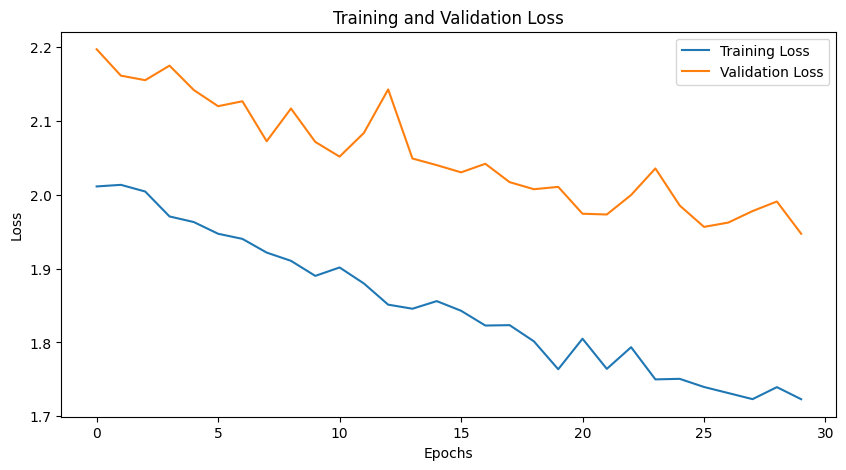

In [2]:
import matplotlib.pyplot as plt

# 검증 데이터 준비 
val_image_folder_path = './data2/val/images'
val_label_folder_path = './data2/val/labels'

# 이미지 파일 경로를 가져옵니다.
validation_image_paths = [os.path.join(val_image_folder_path, img) for img in os.listdir(val_image_folder_path) if img.endswith('.jpg')]

# 각 이미지에 대응하는 라벨 파일을 읽어옵니다.
validation_labels = []
for img_path in validation_image_paths:
    label_path = os.path.join(val_label_folder_path, os.path.basename(img_path).replace('.jpg', '.txt'))
    with open(label_path, 'r') as label_file:
        label = float(label_file.read().split()[0])  # 라벨 파일에서 라벨을 읽어옵니다.
        validation_labels.append(label)

validation_dataset = HandDataset(validation_image_paths, validation_labels)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

# 학습 및 검증 손실과 정확도를 기록하기 위한 리스트
train_losses = []
validation_losses = []

# 에폭 수 정의
num_epochs = 30

# 훈련 루프 수정
for epoch in tqdm(range(num_epochs)):
    model.train()  # 훈련 모드
    train_loss = 0.0
    for batch in dataloader:
        landmarks, labels = batch
        preds = model(landmarks)
        loss = criterion(preds.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    # 검증 루프
    model.eval()  # 평가 모드
    validation_loss = 0.0
    with torch.no_grad():
        for batch in validation_loader:
            landmarks, labels = batch
            preds = model(landmarks)
            loss = criterion(preds.squeeze(), labels)
            validation_loss += loss.item()

    avg_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(avg_validation_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}")

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


- 주어진 학습 및 검증 손실 그래프를 보면, 훈련 손실은 점차 감소하는 반면 검증 손실은 일정한 경향을 보이고 있다.
- 이는 모델이 훈련 데이터에는 점차 적합해지고 있지만, 검증 데이터에 대해서는 개선이 제한적임을 의미할 수 있다.
- 이런 경우, 모델이 검증 데이터에 대해 더 잘 일반화되도록 하기 위한 몇 가지 전략을 적용해야함.

## 모델 저장

In [3]:
save_model_path = './' # 경로 설정

torch.save(model, save_model_path + 'model.pt') # 모델 저장
torch.save(model.state_dict(), save_model_path + 'hand_model.pth') # 모델 객체의 state_dict 저장

## 모델 개선
- 모델 학습에 학습률 스케줄러 업데이트 추가

In [32]:
import os
import mediapipe as mp
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# MediaPipe 손 모델 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

# 데이터셋 클래스 정의
class HandDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        # 이미지 로드 및 랜드마크 검출
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        
        # 랜드마크 추출 및 전처리
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0]
            # mediapipe 랜드마크 x, y, z좌표를 가짐
            landmarks = [(lm.x, lm.y, lm.z) for lm in landmarks.landmark]
            landmarks = torch.tensor(landmarks).flatten()
            
        else:
            landmarks = torch.zeros(63) # 21 * 3 (x, y, z)
            
        # nn.CrossEntropyLoss는 타켓 라벨로 정수형 텐서를 사용해야 함. -> torch.long
        label = torch.tensor(self.labels[idx], dtype=torch.long) 
        return landmarks, label
    
# 신경망 모델 정의
class HandStateNN(nn.Module):
    def __init__(self, n_classes):
        super(HandStateNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(63, 32), # 21 랜드마크 * 3 (x, y, z)
            nn.ReLU(),
            nn.Linear(32, n_classes),  # n_classes: 분류할 클래스 수
        )
    
    def forward(self, x):
        return self.fc(x)
    
# 학습 데이터 준비
image_folder_path = './data2/train/images'
label_folder_path = './data2/train/labels'

# 이미지 파일 경로를 가져옵니다.
image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith('.jpg')]

# 각 이미지에 대응하는 라벨 파일을 읽어옵니다.
labels = []
for img_path in image_paths:
    label_path = os.path.join(label_folder_path, os.path.basename(img_path).replace('.jpg', '.txt'))
    with open(label_path, 'r') as label_file:
        label = float(label_file.read().split()[0])  # 라벨 파일에서 라벨을 읽어옵니다.
        labels.append(label)

# 에폭 수 정의
num_epochs = 20

dataset = HandDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 모델 초기화
n_classes = 11 # 분류할 클래스 수
model = HandStateNN(n_classes)

# 손실 함수 및 최적화기 정의
criterion = nn.CrossEntropyLoss() # 내부적으로 softmax 실행

# 학습률, 스케줄러 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # 10 에폭마다 학습률을 0.1배 감소

# 훈련 루프
for epoch in tqdm(range(num_epochs)):
    for batch in dataloader:
        landmarks, labels = batch 
        preds = model(landmarks)
        loss = criterion(preds.squeeze(), labels)
         
        optimizer.zero_grad() # 모델 매개변수의 변화도를 재설정
        loss.backward() # 예측 손실(prediction loss)을 역전파
        optimizer.step() # 역전파 단계에서 수집된 변화도로 매개변수를 조정
        scheduler.step()
        
        print(f"Epoch {epoch}, Loss: {loss.item()}")

  0%|                                                    | 0/20 [00:00<?, ?it/s]/var/folders/nc/lry6d8ws417_mblykm_8wpc40000gn/T/ipykernel_5558/527830283.py:40: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 0, Loss: 2.35040545463562
Epoch 0, Loss: 2.3364663124084473
Epoch 0, Loss: 2.4424009323120117
Epoch 0, Loss: 2.434906244277954
Epoch 0, Loss: 2.5048441886901855
Epoch 0, Loss: 2.5087265968322754
Epoch 0, Loss: 2.3440029621124268
Epoch 0, Loss: 2.4747700691223145
Epoch 0, Loss: 2.414987087249756
Epoch 0, Loss: 2.3982393741607666
Epoch 0, Loss: 2.4853124618530273
Epoch 0, Loss: 2.4597668647766113
Epoch 0, Loss: 2.3697314262390137
Epoch 0, Loss: 2.3253042697906494
Epoch 0, Loss: 2.4121487140655518
Epoch 0, Loss: 2.4341254234313965
Epoch 0, Loss: 2.475527763366699
Epoch 0, Loss: 2.2898237705230713
Epoch 0, Loss: 2.391568660736084
Epoch 0, Loss: 2.458008289337158
Epoch 0, Loss: 2.4097816944122314
Epoch 0, Loss: 2.3672852516174316
Epoch 0, Loss: 2.4764671325683594
Epoch 0, Loss: 2.3318419456481934
Epoch 0, Loss: 2.326234817504883
Epoch 0, Loss: 2.381983757019043
Epoch 0, Loss: 2.473139762878418
Epoch 0, Loss: 2.333130359649658
Epoch 0, Loss: 2.4593358039855957
Epoch 0, Loss: 2.37308883

  5%|██▏                                         | 1/20 [00:07<02:26,  7.73s/it]

Epoch 0, Loss: 2.53269362449646
Epoch 1, Loss: 2.4629335403442383
Epoch 1, Loss: 2.398190975189209
Epoch 1, Loss: 2.420222520828247
Epoch 1, Loss: 2.351161479949951
Epoch 1, Loss: 2.3454580307006836
Epoch 1, Loss: 2.374825954437256
Epoch 1, Loss: 2.4106802940368652
Epoch 1, Loss: 2.3438539505004883
Epoch 1, Loss: 2.366455078125
Epoch 1, Loss: 2.509993314743042
Epoch 1, Loss: 2.378438949584961
Epoch 1, Loss: 2.3921711444854736
Epoch 1, Loss: 2.3740739822387695
Epoch 1, Loss: 2.4231038093566895
Epoch 1, Loss: 2.433896064758301
Epoch 1, Loss: 2.253631830215454
Epoch 1, Loss: 2.401845932006836
Epoch 1, Loss: 2.3935272693634033
Epoch 1, Loss: 2.4690561294555664
Epoch 1, Loss: 2.424649238586426
Epoch 1, Loss: 2.3768131732940674
Epoch 1, Loss: 2.3570828437805176
Epoch 1, Loss: 2.5412700176239014
Epoch 1, Loss: 2.3359768390655518
Epoch 1, Loss: 2.4089221954345703
Epoch 1, Loss: 2.465147018432617
Epoch 1, Loss: 2.484318256378174
Epoch 1, Loss: 2.4769127368927
Epoch 1, Loss: 2.3160526752471924
E

 10%|████▍                                       | 2/20 [00:15<02:17,  7.64s/it]

Epoch 1, Loss: 2.358125925064087
Epoch 1, Loss: 2.426028251647949
Epoch 1, Loss: 2.3598713874816895
Epoch 2, Loss: 2.3617000579833984
Epoch 2, Loss: 2.3305721282958984
Epoch 2, Loss: 2.4992997646331787
Epoch 2, Loss: 2.4167251586914062
Epoch 2, Loss: 2.4560141563415527
Epoch 2, Loss: 2.5102667808532715
Epoch 2, Loss: 2.4874846935272217
Epoch 2, Loss: 2.273449659347534
Epoch 2, Loss: 2.4607279300689697
Epoch 2, Loss: 2.4110941886901855
Epoch 2, Loss: 2.4804234504699707
Epoch 2, Loss: 2.2992770671844482
Epoch 2, Loss: 2.3212289810180664
Epoch 2, Loss: 2.514214038848877
Epoch 2, Loss: 2.508227825164795
Epoch 2, Loss: 2.47000789642334
Epoch 2, Loss: 2.4771270751953125
Epoch 2, Loss: 2.4216930866241455
Epoch 2, Loss: 2.34438419342041
Epoch 2, Loss: 2.316899299621582
Epoch 2, Loss: 2.40360689163208
Epoch 2, Loss: 2.444288730621338
Epoch 2, Loss: 2.323148250579834
Epoch 2, Loss: 2.3824398517608643
Epoch 2, Loss: 2.439901351928711
Epoch 2, Loss: 2.494333505630493
Epoch 2, Loss: 2.4026820659637

 15%|██████▌                                     | 3/20 [00:22<02:07,  7.52s/it]

Epoch 2, Loss: 2.4359986782073975
Epoch 2, Loss: 2.461113452911377
Epoch 2, Loss: 2.343614101409912
Epoch 3, Loss: 2.3757874965667725
Epoch 3, Loss: 2.377645969390869
Epoch 3, Loss: 2.381439685821533
Epoch 3, Loss: 2.3431668281555176
Epoch 3, Loss: 2.3700106143951416
Epoch 3, Loss: 2.348374366760254
Epoch 3, Loss: 2.262803077697754
Epoch 3, Loss: 2.4887795448303223
Epoch 3, Loss: 2.3542513847351074
Epoch 3, Loss: 2.4332311153411865
Epoch 3, Loss: 2.49025297164917
Epoch 3, Loss: 2.479382038116455
Epoch 3, Loss: 2.384418249130249
Epoch 3, Loss: 2.5324783325195312
Epoch 3, Loss: 2.506361484527588
Epoch 3, Loss: 2.4084253311157227
Epoch 3, Loss: 2.4837117195129395
Epoch 3, Loss: 2.4580655097961426
Epoch 3, Loss: 2.2845425605773926
Epoch 3, Loss: 2.3260767459869385
Epoch 3, Loss: 2.3445396423339844
Epoch 3, Loss: 2.372982978820801
Epoch 3, Loss: 2.4450602531433105
Epoch 3, Loss: 2.3422045707702637
Epoch 3, Loss: 2.49238920211792
Epoch 3, Loss: 2.468161106109619
Epoch 3, Loss: 2.365999937057

 20%|████████▊                                   | 4/20 [00:30<01:59,  7.48s/it]

Epoch 3, Loss: 2.4349114894866943
Epoch 3, Loss: 2.4026777744293213
Epoch 3, Loss: 2.490327835083008
Epoch 4, Loss: 2.4579122066497803
Epoch 4, Loss: 2.3741848468780518
Epoch 4, Loss: 2.3714091777801514
Epoch 4, Loss: 2.449307441711426
Epoch 4, Loss: 2.4717893600463867
Epoch 4, Loss: 2.4199790954589844
Epoch 4, Loss: 2.422117233276367
Epoch 4, Loss: 2.317516326904297
Epoch 4, Loss: 2.4322872161865234
Epoch 4, Loss: 2.5112247467041016
Epoch 4, Loss: 2.4371485710144043
Epoch 4, Loss: 2.390986442565918
Epoch 4, Loss: 2.3248767852783203
Epoch 4, Loss: 2.3811514377593994
Epoch 4, Loss: 2.2550179958343506
Epoch 4, Loss: 2.4030275344848633
Epoch 4, Loss: 2.3856096267700195
Epoch 4, Loss: 2.440232276916504
Epoch 4, Loss: 2.2797863483428955
Epoch 4, Loss: 2.4313361644744873
Epoch 4, Loss: 2.3747541904449463
Epoch 4, Loss: 2.4071693420410156
Epoch 4, Loss: 2.428858518600464
Epoch 4, Loss: 2.494800567626953
Epoch 4, Loss: 2.3977465629577637
Epoch 4, Loss: 2.319720506668091
Epoch 4, Loss: 2.490567

 25%|███████████                                 | 5/20 [00:37<01:52,  7.50s/it]

Epoch 4, Loss: 2.4307303428649902
Epoch 4, Loss: 2.3494691848754883
Epoch 5, Loss: 2.395353317260742
Epoch 5, Loss: 2.2794408798217773
Epoch 5, Loss: 2.5355684757232666
Epoch 5, Loss: 2.4461183547973633
Epoch 5, Loss: 2.5546321868896484
Epoch 5, Loss: 2.3914601802825928
Epoch 5, Loss: 2.4484691619873047
Epoch 5, Loss: 2.5236306190490723
Epoch 5, Loss: 2.478933572769165
Epoch 5, Loss: 2.3927459716796875
Epoch 5, Loss: 2.3025741577148438
Epoch 5, Loss: 2.4078280925750732
Epoch 5, Loss: 2.274691581726074
Epoch 5, Loss: 2.366783857345581
Epoch 5, Loss: 2.4125161170959473
Epoch 5, Loss: 2.4861741065979004
Epoch 5, Loss: 2.358306646347046
Epoch 5, Loss: 2.3794360160827637
Epoch 5, Loss: 2.5400705337524414
Epoch 5, Loss: 2.389972448348999
Epoch 5, Loss: 2.5105509757995605
Epoch 5, Loss: 2.4512364864349365
Epoch 5, Loss: 2.4644463062286377
Epoch 5, Loss: 2.4028515815734863
Epoch 5, Loss: 2.4169673919677734
Epoch 5, Loss: 2.473172903060913
Epoch 5, Loss: 2.3802297115325928
Epoch 5, Loss: 2.5189

 30%|█████████████▏                              | 6/20 [00:45<01:44,  7.50s/it]

Epoch 5, Loss: 2.1987714767456055
Epoch 6, Loss: 2.4134931564331055
Epoch 6, Loss: 2.2770369052886963
Epoch 6, Loss: 2.5167229175567627
Epoch 6, Loss: 2.4006104469299316
Epoch 6, Loss: 2.4437754154205322
Epoch 6, Loss: 2.3894529342651367
Epoch 6, Loss: 2.471890926361084
Epoch 6, Loss: 2.3829505443573
Epoch 6, Loss: 2.3948111534118652
Epoch 6, Loss: 2.2749273777008057
Epoch 6, Loss: 2.4143173694610596
Epoch 6, Loss: 2.2806546688079834
Epoch 6, Loss: 2.3923532962799072
Epoch 6, Loss: 2.398045301437378
Epoch 6, Loss: 2.397653102874756
Epoch 6, Loss: 2.4269113540649414
Epoch 6, Loss: 2.4081199169158936
Epoch 6, Loss: 2.4213714599609375
Epoch 6, Loss: 2.4059431552886963
Epoch 6, Loss: 2.438599109649658
Epoch 6, Loss: 2.455813407897949
Epoch 6, Loss: 2.4876461029052734
Epoch 6, Loss: 2.407437801361084
Epoch 6, Loss: 2.439387321472168
Epoch 6, Loss: 2.4411120414733887
Epoch 6, Loss: 2.364678144454956
Epoch 6, Loss: 2.3077962398529053
Epoch 6, Loss: 2.286487579345703
Epoch 6, Loss: 2.424039363

 35%|███████████████▍                            | 7/20 [00:52<01:37,  7.49s/it]

Epoch 6, Loss: 2.333408832550049
Epoch 6, Loss: 2.451853036880493
Epoch 6, Loss: 2.3652641773223877
Epoch 7, Loss: 2.509298086166382
Epoch 7, Loss: 2.392695903778076
Epoch 7, Loss: 2.5223028659820557
Epoch 7, Loss: 2.430893659591675
Epoch 7, Loss: 2.4260902404785156
Epoch 7, Loss: 2.3774614334106445
Epoch 7, Loss: 2.42684268951416
Epoch 7, Loss: 2.373661518096924
Epoch 7, Loss: 2.270198345184326
Epoch 7, Loss: 2.389876365661621
Epoch 7, Loss: 2.470583200454712
Epoch 7, Loss: 2.3744261264801025
Epoch 7, Loss: 2.4240550994873047
Epoch 7, Loss: 2.2962687015533447
Epoch 7, Loss: 2.4820399284362793
Epoch 7, Loss: 2.444190263748169
Epoch 7, Loss: 2.478729486465454
Epoch 7, Loss: 2.4525866508483887
Epoch 7, Loss: 2.3092756271362305
Epoch 7, Loss: 2.3906028270721436
Epoch 7, Loss: 2.3144445419311523
Epoch 7, Loss: 2.320491313934326
Epoch 7, Loss: 2.3937201499938965
Epoch 7, Loss: 2.3606812953948975
Epoch 7, Loss: 2.3717446327209473
Epoch 7, Loss: 2.425997257232666
Epoch 7, Loss: 2.344397068023

 40%|█████████████████▌                          | 8/20 [01:00<01:29,  7.46s/it]

Epoch 7, Loss: 2.460364818572998
Epoch 8, Loss: 2.348923444747925
Epoch 8, Loss: 2.3283135890960693
Epoch 8, Loss: 2.4268481731414795
Epoch 8, Loss: 2.3575289249420166
Epoch 8, Loss: 2.371022939682007
Epoch 8, Loss: 2.3166933059692383
Epoch 8, Loss: 2.423715114593506
Epoch 8, Loss: 2.354957103729248
Epoch 8, Loss: 2.3044636249542236
Epoch 8, Loss: 2.471153497695923
Epoch 8, Loss: 2.4458861351013184
Epoch 8, Loss: 2.3947556018829346
Epoch 8, Loss: 2.4428460597991943
Epoch 8, Loss: 2.365936517715454
Epoch 8, Loss: 2.3178648948669434
Epoch 8, Loss: 2.317105531692505
Epoch 8, Loss: 2.5173847675323486
Epoch 8, Loss: 2.5141100883483887
Epoch 8, Loss: 2.424818754196167
Epoch 8, Loss: 2.466801881790161
Epoch 8, Loss: 2.4118707180023193
Epoch 8, Loss: 2.449456214904785
Epoch 8, Loss: 2.5392632484436035
Epoch 8, Loss: 2.477933168411255
Epoch 8, Loss: 2.4670472145080566
Epoch 8, Loss: 2.490190029144287
Epoch 8, Loss: 2.3776772022247314
Epoch 8, Loss: 2.4304986000061035
Epoch 8, Loss: 2.5216703414

 45%|███████████████████▊                        | 9/20 [01:07<01:22,  7.48s/it]

Epoch 8, Loss: 2.483015537261963
Epoch 8, Loss: 2.4322643280029297
Epoch 9, Loss: 2.3985657691955566
Epoch 9, Loss: 2.2898006439208984
Epoch 9, Loss: 2.3845202922821045
Epoch 9, Loss: 2.413539409637451
Epoch 9, Loss: 2.330317258834839
Epoch 9, Loss: 2.428518295288086
Epoch 9, Loss: 2.338895320892334
Epoch 9, Loss: 2.3888814449310303
Epoch 9, Loss: 2.400315761566162
Epoch 9, Loss: 2.4225149154663086
Epoch 9, Loss: 2.3984127044677734
Epoch 9, Loss: 2.4168577194213867
Epoch 9, Loss: 2.4982404708862305
Epoch 9, Loss: 2.460789918899536
Epoch 9, Loss: 2.4203290939331055
Epoch 9, Loss: 2.281365394592285
Epoch 9, Loss: 2.50189208984375
Epoch 9, Loss: 2.499647378921509
Epoch 9, Loss: 2.388134241104126
Epoch 9, Loss: 2.368469715118408
Epoch 9, Loss: 2.4471399784088135
Epoch 9, Loss: 2.4582324028015137
Epoch 9, Loss: 2.347595453262329
Epoch 9, Loss: 2.4195425510406494
Epoch 9, Loss: 2.371964454650879
Epoch 9, Loss: 2.407043695449829
Epoch 9, Loss: 2.3997018337249756
Epoch 9, Loss: 2.4525718688964

 50%|█████████████████████▌                     | 10/20 [01:14<01:14,  7.46s/it]

Epoch 9, Loss: 2.446361541748047
Epoch 9, Loss: 2.5132033824920654
Epoch 9, Loss: 2.480703353881836
Epoch 10, Loss: 2.4535341262817383
Epoch 10, Loss: 2.4202659130096436
Epoch 10, Loss: 2.3615403175354004
Epoch 10, Loss: 2.4368391036987305
Epoch 10, Loss: 2.4307918548583984
Epoch 10, Loss: 2.401282548904419
Epoch 10, Loss: 2.3632442951202393
Epoch 10, Loss: 2.4670798778533936
Epoch 10, Loss: 2.465557813644409
Epoch 10, Loss: 2.406714916229248
Epoch 10, Loss: 2.4733309745788574
Epoch 10, Loss: 2.344935894012451
Epoch 10, Loss: 2.3890469074249268
Epoch 10, Loss: 2.38950777053833
Epoch 10, Loss: 2.3899340629577637
Epoch 10, Loss: 2.3468620777130127
Epoch 10, Loss: 2.354234457015991
Epoch 10, Loss: 2.4275546073913574
Epoch 10, Loss: 2.460151195526123
Epoch 10, Loss: 2.440333366394043
Epoch 10, Loss: 2.390738010406494
Epoch 10, Loss: 2.421893835067749
Epoch 10, Loss: 2.357433795928955
Epoch 10, Loss: 2.4464964866638184
Epoch 10, Loss: 2.4089853763580322
Epoch 10, Loss: 2.328042507171631
Epo

 55%|███████████████████████▋                   | 11/20 [01:22<01:07,  7.49s/it]

Epoch 10, Loss: 2.416417121887207
Epoch 10, Loss: 2.5754308700561523
Epoch 10, Loss: 2.4509246349334717
Epoch 11, Loss: 2.36777925491333
Epoch 11, Loss: 2.368818521499634
Epoch 11, Loss: 2.423581123352051
Epoch 11, Loss: 2.4754090309143066
Epoch 11, Loss: 2.374128818511963
Epoch 11, Loss: 2.296339273452759
Epoch 11, Loss: 2.4911742210388184
Epoch 11, Loss: 2.43588924407959
Epoch 11, Loss: 2.39137601852417
Epoch 11, Loss: 2.371454954147339
Epoch 11, Loss: 2.3212764263153076
Epoch 11, Loss: 2.4580912590026855
Epoch 11, Loss: 2.378284454345703
Epoch 11, Loss: 2.4122633934020996
Epoch 11, Loss: 2.551727294921875
Epoch 11, Loss: 2.361318349838257
Epoch 11, Loss: 2.4673333168029785
Epoch 11, Loss: 2.441434860229492
Epoch 11, Loss: 2.4487242698669434
Epoch 11, Loss: 2.3822784423828125
Epoch 11, Loss: 2.386911630630493
Epoch 11, Loss: 2.3962700366973877
Epoch 11, Loss: 2.3924381732940674
Epoch 11, Loss: 2.5523130893707275
Epoch 11, Loss: 2.4601891040802
Epoch 11, Loss: 2.4569056034088135
Epoch

 60%|█████████████████████████▊                 | 12/20 [01:29<00:59,  7.46s/it]

Epoch 11, Loss: 2.407756805419922
Epoch 11, Loss: 2.4763236045837402
Epoch 11, Loss: 2.510016918182373
Epoch 12, Loss: 2.288870334625244
Epoch 12, Loss: 2.4583981037139893
Epoch 12, Loss: 2.3792309761047363
Epoch 12, Loss: 2.3693110942840576
Epoch 12, Loss: 2.408921718597412
Epoch 12, Loss: 2.4153974056243896
Epoch 12, Loss: 2.425354242324829
Epoch 12, Loss: 2.3370296955108643
Epoch 12, Loss: 2.2909445762634277
Epoch 12, Loss: 2.3165712356567383
Epoch 12, Loss: 2.356032371520996
Epoch 12, Loss: 2.481809139251709
Epoch 12, Loss: 2.366504192352295
Epoch 12, Loss: 2.356140613555908
Epoch 12, Loss: 2.378232479095459
Epoch 12, Loss: 2.501542568206787
Epoch 12, Loss: 2.3860583305358887
Epoch 12, Loss: 2.416970729827881
Epoch 12, Loss: 2.4572577476501465
Epoch 12, Loss: 2.3283228874206543
Epoch 12, Loss: 2.3751063346862793
Epoch 12, Loss: 2.3835954666137695
Epoch 12, Loss: 2.502537488937378
Epoch 12, Loss: 2.2761082649230957
Epoch 12, Loss: 2.384063720703125
Epoch 12, Loss: 2.4311180114746094

 65%|███████████████████████████▉               | 13/20 [01:37<00:52,  7.49s/it]

Epoch 12, Loss: 2.526801109313965
Epoch 13, Loss: 2.404141426086426
Epoch 13, Loss: 2.3064606189727783
Epoch 13, Loss: 2.4680709838867188
Epoch 13, Loss: 2.3587071895599365
Epoch 13, Loss: 2.4437131881713867
Epoch 13, Loss: 2.404662609100342
Epoch 13, Loss: 2.3837060928344727
Epoch 13, Loss: 2.414599895477295
Epoch 13, Loss: 2.4356703758239746
Epoch 13, Loss: 2.450260639190674
Epoch 13, Loss: 2.5207321643829346
Epoch 13, Loss: 2.327209711074829
Epoch 13, Loss: 2.4076316356658936
Epoch 13, Loss: 2.442805767059326
Epoch 13, Loss: 2.4080653190612793
Epoch 13, Loss: 2.4104056358337402
Epoch 13, Loss: 2.351630210876465
Epoch 13, Loss: 2.400726079940796
Epoch 13, Loss: 2.504342794418335
Epoch 13, Loss: 2.3032984733581543
Epoch 13, Loss: 2.552133083343506
Epoch 13, Loss: 2.442894458770752
Epoch 13, Loss: 2.4325473308563232
Epoch 13, Loss: 2.4628944396972656
Epoch 13, Loss: 2.406107187271118
Epoch 13, Loss: 2.454103946685791
Epoch 13, Loss: 2.3662631511688232
Epoch 13, Loss: 2.37428879737854
E

 70%|██████████████████████████████             | 14/20 [01:44<00:44,  7.48s/it]

Epoch 13, Loss: 2.445906162261963
Epoch 13, Loss: 2.4783482551574707
Epoch 13, Loss: 2.324162483215332
Epoch 14, Loss: 2.3962934017181396
Epoch 14, Loss: 2.4771485328674316
Epoch 14, Loss: 2.329479694366455
Epoch 14, Loss: 2.446021556854248
Epoch 14, Loss: 2.327888011932373
Epoch 14, Loss: 2.3391034603118896
Epoch 14, Loss: 2.417705535888672
Epoch 14, Loss: 2.319157123565674
Epoch 14, Loss: 2.4071874618530273
Epoch 14, Loss: 2.4324252605438232
Epoch 14, Loss: 2.4588780403137207
Epoch 14, Loss: 2.4971532821655273
Epoch 14, Loss: 2.490098237991333
Epoch 14, Loss: 2.2524614334106445
Epoch 14, Loss: 2.3380792140960693
Epoch 14, Loss: 2.468977689743042
Epoch 14, Loss: 2.4441676139831543
Epoch 14, Loss: 2.32891845703125
Epoch 14, Loss: 2.4596190452575684
Epoch 14, Loss: 2.388404369354248
Epoch 14, Loss: 2.400071144104004
Epoch 14, Loss: 2.393704414367676
Epoch 14, Loss: 2.448793888092041
Epoch 14, Loss: 2.403491735458374
Epoch 14, Loss: 2.501321792602539
Epoch 14, Loss: 2.2727513313293457
Ep

 75%|████████████████████████████████▎          | 15/20 [01:52<00:37,  7.47s/it]

Epoch 14, Loss: 2.300009250640869
Epoch 14, Loss: 2.4914591312408447
Epoch 14, Loss: 2.446861743927002
Epoch 15, Loss: 2.4617867469787598
Epoch 15, Loss: 2.378774642944336
Epoch 15, Loss: 2.459167718887329
Epoch 15, Loss: 2.3809847831726074
Epoch 15, Loss: 2.4156017303466797
Epoch 15, Loss: 2.4248714447021484
Epoch 15, Loss: 2.3225626945495605
Epoch 15, Loss: 2.2804644107818604
Epoch 15, Loss: 2.416809558868408
Epoch 15, Loss: 2.370262384414673
Epoch 15, Loss: 2.387920618057251
Epoch 15, Loss: 2.365473747253418
Epoch 15, Loss: 2.32674503326416
Epoch 15, Loss: 2.387279748916626
Epoch 15, Loss: 2.3896210193634033
Epoch 15, Loss: 2.393825054168701
Epoch 15, Loss: 2.4304943084716797
Epoch 15, Loss: 2.3457260131835938
Epoch 15, Loss: 2.2551116943359375
Epoch 15, Loss: 2.4018588066101074
Epoch 15, Loss: 2.4643404483795166
Epoch 15, Loss: 2.4472455978393555
Epoch 15, Loss: 2.455381393432617
Epoch 15, Loss: 2.4933831691741943
Epoch 15, Loss: 2.425583600997925
Epoch 15, Loss: 2.355938196182251


 80%|██████████████████████████████████▍        | 16/20 [01:59<00:29,  7.46s/it]

Epoch 15, Loss: 2.494126319885254
Epoch 15, Loss: 2.357909679412842
Epoch 15, Loss: 2.573652744293213
Epoch 16, Loss: 2.3659567832946777
Epoch 16, Loss: 2.504002094268799
Epoch 16, Loss: 2.3130311965942383
Epoch 16, Loss: 2.3889126777648926
Epoch 16, Loss: 2.5047597885131836
Epoch 16, Loss: 2.380396604537964
Epoch 16, Loss: 2.410881996154785
Epoch 16, Loss: 2.372450351715088
Epoch 16, Loss: 2.3661935329437256
Epoch 16, Loss: 2.446098566055298
Epoch 16, Loss: 2.431307554244995
Epoch 16, Loss: 2.477221965789795
Epoch 16, Loss: 2.3460187911987305
Epoch 16, Loss: 2.440890073776245
Epoch 16, Loss: 2.402730941772461
Epoch 16, Loss: 2.356658697128296
Epoch 16, Loss: 2.3309433460235596
Epoch 16, Loss: 2.4360647201538086
Epoch 16, Loss: 2.3785078525543213
Epoch 16, Loss: 2.334751605987549
Epoch 16, Loss: 2.438689708709717
Epoch 16, Loss: 2.4012598991394043
Epoch 16, Loss: 2.4245057106018066
Epoch 16, Loss: 2.275665521621704
Epoch 16, Loss: 2.4295172691345215
Epoch 16, Loss: 2.3847389221191406
E

 85%|████████████████████████████████████▌      | 17/20 [02:07<00:22,  7.47s/it]

Epoch 16, Loss: 2.4806385040283203
Epoch 16, Loss: 2.3799777030944824
Epoch 16, Loss: 2.4078171253204346
Epoch 17, Loss: 2.495190143585205
Epoch 17, Loss: 2.4089508056640625
Epoch 17, Loss: 2.45648455619812
Epoch 17, Loss: 2.4535555839538574
Epoch 17, Loss: 2.3954548835754395
Epoch 17, Loss: 2.405867576599121
Epoch 17, Loss: 2.397217035293579
Epoch 17, Loss: 2.4617979526519775
Epoch 17, Loss: 2.388122081756592
Epoch 17, Loss: 2.355916976928711
Epoch 17, Loss: 2.3865790367126465
Epoch 17, Loss: 2.476320743560791
Epoch 17, Loss: 2.5286011695861816
Epoch 17, Loss: 2.397097110748291
Epoch 17, Loss: 2.355978012084961
Epoch 17, Loss: 2.3906211853027344
Epoch 17, Loss: 2.4703803062438965
Epoch 17, Loss: 2.528207302093506
Epoch 17, Loss: 2.3949389457702637
Epoch 17, Loss: 2.482081651687622
Epoch 17, Loss: 2.3824074268341064
Epoch 17, Loss: 2.3443121910095215
Epoch 17, Loss: 2.332491397857666
Epoch 17, Loss: 2.4871087074279785
Epoch 17, Loss: 2.372500419616699
Epoch 17, Loss: 2.4033303260803223

 90%|██████████████████████████████████████▋    | 18/20 [02:14<00:14,  7.46s/it]

Epoch 17, Loss: 2.348837375640869
Epoch 17, Loss: 2.5047104358673096
Epoch 18, Loss: 2.463411808013916
Epoch 18, Loss: 2.409604072570801
Epoch 18, Loss: 2.4025468826293945
Epoch 18, Loss: 2.467252016067505
Epoch 18, Loss: 2.4106459617614746
Epoch 18, Loss: 2.4853410720825195
Epoch 18, Loss: 2.324481964111328
Epoch 18, Loss: 2.4609947204589844
Epoch 18, Loss: 2.5038022994995117
Epoch 18, Loss: 2.444103717803955
Epoch 18, Loss: 2.3665518760681152
Epoch 18, Loss: 2.326777696609497
Epoch 18, Loss: 2.443302869796753
Epoch 18, Loss: 2.3633081912994385
Epoch 18, Loss: 2.3470406532287598
Epoch 18, Loss: 2.517340660095215
Epoch 18, Loss: 2.400167465209961
Epoch 18, Loss: 2.2932610511779785
Epoch 18, Loss: 2.330470323562622
Epoch 18, Loss: 2.496110200881958
Epoch 18, Loss: 2.3284003734588623
Epoch 18, Loss: 2.4476637840270996
Epoch 18, Loss: 2.408599853515625
Epoch 18, Loss: 2.363509178161621
Epoch 18, Loss: 2.3979079723358154
Epoch 18, Loss: 2.4913220405578613
Epoch 18, Loss: 2.3519554138183594

 95%|████████████████████████████████████████▊  | 19/20 [02:22<00:07,  7.46s/it]

Epoch 18, Loss: 2.425837755203247
Epoch 18, Loss: 2.3748960494995117
Epoch 19, Loss: 2.3763773441314697
Epoch 19, Loss: 2.41546368598938
Epoch 19, Loss: 2.4701006412506104
Epoch 19, Loss: 2.4700798988342285
Epoch 19, Loss: 2.4633095264434814
Epoch 19, Loss: 2.426889181137085
Epoch 19, Loss: 2.376967668533325
Epoch 19, Loss: 2.405083417892456
Epoch 19, Loss: 2.4162747859954834
Epoch 19, Loss: 2.470515727996826
Epoch 19, Loss: 2.456406593322754
Epoch 19, Loss: 2.424877643585205
Epoch 19, Loss: 2.4087626934051514
Epoch 19, Loss: 2.4689621925354004
Epoch 19, Loss: 2.4772348403930664
Epoch 19, Loss: 2.33427357673645
Epoch 19, Loss: 2.3662426471710205
Epoch 19, Loss: 2.382514476776123
Epoch 19, Loss: 2.422278881072998
Epoch 19, Loss: 2.327834367752075
Epoch 19, Loss: 2.329744338989258
Epoch 19, Loss: 2.360854387283325
Epoch 19, Loss: 2.485769033432007
Epoch 19, Loss: 2.400681257247925
Epoch 19, Loss: 2.3274922370910645
Epoch 19, Loss: 2.3844704627990723
Epoch 19, Loss: 2.4452013969421387
Epo

100%|███████████████████████████████████████████| 20/20 [02:29<00:00,  7.48s/it]

Epoch 19, Loss: 2.401918649673462
Epoch 19, Loss: 2.409057140350342
Epoch 19, Loss: 2.387321949005127


- 그렇게 큰 변화는 없음